In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# **Preprocessing**

In [2]:
#Input Data
df = pd.read_excel('E:\SEKOLAH\KULIAH\KEGIATAN SEMESTER\Semester 6\Data Mining\Praktikum\Laprak UAS\Bitcoin time series.xlsx')
dfdate = pd.read_csv('E:\SEKOLAH\KULIAH\KEGIATAN SEMESTER\Semester 6\Data Mining\Praktikum\Laprak UAS\BitcoinPrepocessingdate.csv')
#Drop Unnecessary Column
df = df.drop(columns='Unnamed: 0', axis=1)
dfdate = dfdate.drop(columns='Unnamed: 0', axis=1)

In [3]:
df = df[['Price', 'Open', 'High', 'Low', 'Vol.', 'price t-1', 'price t-2', 'price t-3', 'price t-4', 'price t-5', 'low t-1', 'low t-2',  'low t-3',  'low t-4', 'vol t-1', 'vol t-2']]

# **Split Data**

Split Variable

In [94]:
dfcln = df
x = dfcln.drop(['Price'], axis = 1)
y = dfcln['Price']

Split Train Test

In [95]:
test_size = int(len(df)*0.3)

train_X = x[:-test_size]
train_y = y[:-test_size]
test_X = x[-test_size:]
test_y = y[-test_size:]

In [96]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(3015, 15)
(1292, 15)
(3015,)
(1292,)


# **Modelling**

In [4]:
#for splitting validation and training data
from sklearn.model_selection import train_test_split,TimeSeriesSplit, GridSearchCV, cross_val_score
#for identify model
from sklearn.ensemble import RandomForestRegressor
#for Calculate MAE, MSE
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, explained_variance_score, make_scorer
import optuna
import time
from pprint import pprint

In [37]:
rfreg = RandomForestRegressor(random_state=1)

In [38]:
rfreg.fit(train_X, train_y)

RandomForestRegressor(random_state=1)

In [30]:
rfreg_pred = rfreg.predict(test_X)

NameError: name 'rfreg' is not defined

In [40]:
rf_val_mae = mean_absolute_percentage_error(test_y,rfreg_pred)
print('mape = ' , rf_val_mae)

mape =  0.23161540098256428


# **Hyperparameter Tuning**

In [14]:
def objective(trial):
  n_estimators = trial.suggest_int("n_estimators",200,1000)
  max_features = trial.suggest_categorical("max_features",["auto","sqrt"])
  max_depth = trial.suggest_int("max_depth",10,80,log = True)
  min_samples_split = trial.suggest_int("min_samples_split",2,15)
  min_samples_leaf = trial.suggest_int("min_samples_leaf",1,9)
  bootstrap = trial.suggest_categorical("bootstrap",[True,False])
  
  rand = RandomForestRegressor(n_estimators=n_estimators,max_features=max_features,
                                max_depth=max_depth,min_samples_leaf = min_samples_leaf,
                                min_samples_split = min_samples_split,
                                bootstrap = bootstrap)

  score_cr = cross_val_score(rand,train_X,train_y,n_jobs = -1,cv=5,scoring= make_scorer(mean_absolute_percentage_error))
  score = score_cr.mean()

  return score

In [15]:
study = optuna.create_study(direction='minimize')

[I 2022-05-23 03:12:08,549] A new study created in memory with name: no-name-67d7d415-6591-4787-9896-e9c2ac5d363a


In [18]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, timeout=900, n_trials=50)

In [19]:
study.best_trial

FrozenTrial(number=1, values=[2.385296705949674], datetime_start=datetime.datetime(2022, 5, 23, 3, 15, 8, 108093), datetime_complete=datetime.datetime(2022, 5, 23, 3, 17, 21, 955250), params={'n_estimators': 310, 'max_features': 'auto', 'max_depth': 55, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False}, distributions={'n_estimators': IntUniformDistribution(high=1000, low=200, step=1), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt')), 'max_depth': IntLogUniformDistribution(high=80, low=10, step=1), 'min_samples_split': IntUniformDistribution(high=15, low=2, step=1), 'min_samples_leaf': IntUniformDistribution(high=9, low=1, step=1), 'bootstrap': CategoricalDistribution(choices=(True, False))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)

In [ ]:
optuna.visualization.plot_optimization_history(study)

# **Final Model Fitting**

No Random

In [41]:
rfr = RandomForestRegressor(n_estimators=1000,
                                max_features='auto',
                                min_samples_split=3,
                                min_samples_leaf=1,
                                max_depth=28,
                                bootstrap=True,
                                random_state=1)

rfr.fit(train_X, train_y)
y_pred = rfr.predict(test_X)
mae = mean_absolute_error(test_y, y_pred)
mse = mean_squared_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)
explain_var_score = explained_variance_score(test_y, y_pred)
mape = mean_absolute_percentage_error(test_y, y_pred)

In [42]:
print('mape = ' , mape)
print('mae = ' , mae)
print('mse = ' , mse)
print('r2 = ' , r2)
print('varscore = ' , explain_var_score)

mape =  0.2307617854676014
mae =  10324.382528232443
mse =  304297163.1122388
r2 =  0.1609553920240595
varscore =  0.4498853140062


# **VISUAL**

In [19]:
predictiondf = pd.DataFrame(y_pred)
testdate = dfdate[-test_size:].reset_index(drop = True)
testvis = test_y.reset_index(drop = True)
testxvis = test_X.reset_index(drop = True)

<function matplotlib.pyplot.show(close=None, block=None)>

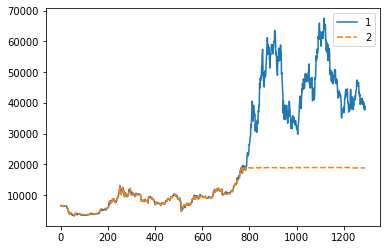

In [20]:
datavis = pd.concat([testdate, testvis, predictiondf], keys=['testdate', 'testvis', 'predictiondf'], names = ['Date', 'Actual', 'Pred'], ignore_index=True, axis=1)
sns.lineplot(data = datavis)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

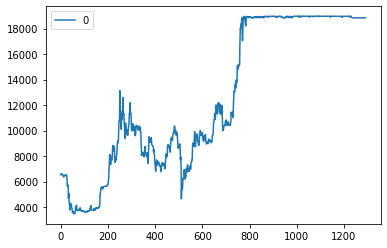

In [21]:
sns.lineplot(data = predictiondf)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

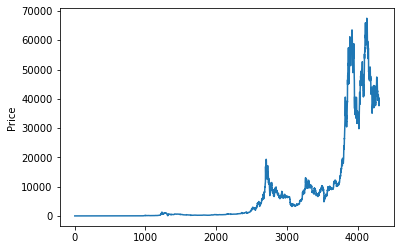

In [44]:
sns.lineplot(data = y)
plt.show

# **Data Start from 2011**

In [6]:
import datetime

In [7]:
dx = pd.concat([dfdate, df], axis = 1)
dx['Date'] = pd.to_datetime(dx['Date'])
dx = dx[dx['Date']>datetime.datetime(2011, 1, 1)].reset_index(drop=True)

In [8]:
test_size = int(len(dx)*0.3)

a = dx.drop(['Price','Date'], axis = 1)
b = dx['Price']

X_train = a[:-test_size]
y_train = b[:-test_size]
x_test = a[-test_size:]
y_test = b[-test_size:]
print(X_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2898, 15)
(1241, 15)
(2898,)
(1241,)


In [9]:
rfrg = RandomForestRegressor(random_state=0)
rfrg.fit(X_train, y_train)
rfrg_pred = rfrg.predict(x_test)
mape = mean_absolute_percentage_error(y_test,rfrg_pred)
print('mape = ' , mape)

mape =  0.2381689512831727


<function matplotlib.pyplot.show(close=None, block=None)>

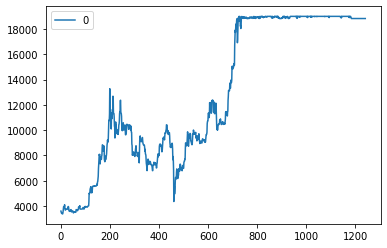

In [10]:
predictiondx = pd.DataFrame(rfrg_pred)
sns.lineplot(data = predictiondx)
plt.show

# **Time Series Split**

In [11]:
arr = np.array(a)
brr = np.array(b)

Tuning

In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 750, stop = 1500, num = 3)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 80, num = 4)]
min_samples_split = [2, 10]
min_samples_leaf = [1, 4]
bootstrap = [True]
para = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfr = RandomForestRegressor(random_state=0,
                            oob_score=True)
#
tscv = TimeSeriesSplit(n_splits=6, test_size=365)
for train_index, val_index in tscv.split(a):
    train_X, val_X = arr[train_index], arr[val_index]
    train_y, val_y = brr[train_index], brr[val_index]

search = GridSearchCV(estimator=rfr,
                      param_grid=para,
                      scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                      cv=tscv,
                      n_jobs=-1,
                      verbose=2)

search.fit(X_train, y_train)

Fitting 6 folds for each of 96 candidates, totalling 576 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=365),
             estimator=RandomForestRegressor(oob_score=True, random_state=0),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 33, 56, 80],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 10],
                         'n_estimators': [750, 1125, 1500]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
             verbose=2)

In [15]:
bestparam = pd.concat([pd.DataFrame(search.cv_results_["rank_test_score"],columns=["Rank"]), pd.DataFrame(search.cv_results_["params"]),pd.DataFrame(search.cv_results_["std_test_score"], columns=["Accuracy"])],axis=1)
bestparam.sort_values(by=['Rank'])

,Rank,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,Accuracy
72,1,True,80,auto,1,2,750,0.216576
24,1,True,33,auto,1,2,750,0.216576
48,1,True,56,auto,1,2,750,0.216576
0,4,True,10,auto,1,2,750,0.216247
25,5,True,33,auto,1,2,1125,0.216768
...,...,...,...,...,...,...,...,...
69,92,True,56,sqrt,4,10,750,0.226063
45,92,True,33,sqrt,4,10,750,0.226063
93,92,True,80,sqrt,4,10,750,0.226063
23,95,True,10,sqrt,4,10,1500,0.226832


Final Model

In [71]:
n_split = []
train_obs = []
test_obs = []
mae_score = []
mape_score = []
pred = []
index = 1
tscv = TimeSeriesSplit(n_splits=6, test_size=365)
for train_index, val_index in tscv.split(a):
    train_X, val_X = arr[train_index], arr[val_index]
    train_y, val_y = brr[train_index], brr[val_index]

    print('enum', index)

    rfr = RandomForestRegressor(n_estimators=750,
                                max_features='auto',
                                min_samples_split=2,
                                min_samples_leaf=1,
                                max_depth=80,
                                bootstrap=True,
                                random_state=0)

    rfr.fit(train_X, train_y)
    y_pred = rfr.predict(val_X)
    mae = mean_absolute_error(val_y, y_pred)
    mape = mean_absolute_percentage_error(val_y, y_pred)*100
    accuracy = 100 - mape
    print('Training Observations: %d' % (len(train_X)))
    print('Testing Observations: %d' % (len(val_y)))
    print(' ')
    print('mape' , mape)
    print('mae' , mae)

    n_split.append(index)
    train_obs.append(len(train_X))
    test_obs.append(len(val_y))
    mae_score.append(mae)
    mape_score.append(mape)
    pred = [y_pred]
    print('-----------------------------')
    index = index + 1


enum 1
Training Observations: 1949
Testing Observations: 365
 
mape 2.0619407256286264
mae 19.442252054795006
-----------------------------
enum 2
Training Observations: 2314
Testing Observations: 365
 
mape 68.42443150392793
mae 5486.738856986302
-----------------------------
enum 3
Training Observations: 2679
Testing Observations: 365
 
mape 2.299013867883461
mae 119.32429333333332
-----------------------------
enum 4
Training Observations: 3044
Testing Observations: 365
 
mape 1.7842143225999392
mae 150.85597260273556
-----------------------------
enum 5
Training Observations: 3409
Testing Observations: 365
 
mape 21.64317791216761
mae 10215.898118721467
-----------------------------
enum 6
Training Observations: 3774
Testing Observations: 365
 
mape 2.500492035709715
mae 1098.9309150685087
-----------------------------


In [74]:
n_split

[1, 2, 3, 4, 5, 6]

In [76]:
itermod = pd.concat([pd.DataFrame(n_split, columns=['n step']),pd.DataFrame(train_obs, columns=['n train']),pd.DataFrame(test_obs, columns=['n_test'])],axis=1)

In [78]:
itermod

,n step,n train,n_test
0,1,1949,365
1,2,2314,365
2,3,2679,365
3,4,3044,365
4,5,3409,365
5,6,3774,365


In [20]:
mse = mean_squared_error(val_y, y_pred)
r2 = r2_score(val_y, y_pred)
explain_var_score = explained_variance_score(val_y, y_pred)

In [21]:
print('mape = ' , mape)
print('mae = ' , mae)
print('mse = ' , mse)
print('r2 = ' , r2)
print('varscore = ' , explain_var_score)

mape =  2.500492035709715
mae =  1098.9309150685087
mse =  1975322.0040201526
r2 =  0.9727632485789112
varscore =  0.973929072643718


Visualisasi

In [33]:
dfdate.tail()

,Date
4302,2022-04-28
4303,2022-04-29
4304,2022-04-30
4305,2022-05-01
4306,2022-05-02


In [35]:
predictiondx = pd.DataFrame(y_pred)
testdate = dfdate.iloc[3774:3882, 0].reset_index(drop=True)
testvis = pd.DataFrame(val_y)

In [58]:
datavis = pd.concat([testdate, testvis, predictiondx], keys=['testdate', 'testvis', 'predictiondf'], names= ['Date', 'Actual', 'Pred'], ignore_index=True, axis=1)
datavis = datavis.rename(columns={0: "Date", 1: "Actual", 2:"Pred"})

In [59]:
df_long = datavis.melt('Date', var_name='Cond', value_name='Value')

<function matplotlib.pyplot.show(close=None, block=None)>

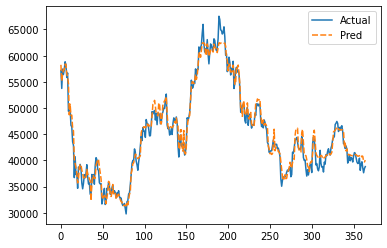

In [84]:
sns.lineplot(data = datavis)
plt.show

Feature Selection

In [80]:
import shap

In [94]:
a.columns

Index(['Open', 'High', 'Low', 'Vol.', 'price t-1', 'price t-2', 'price t-3',
       'price t-4', 'price t-5', 'low t-1', 'low t-2', 'low t-3', 'low t-4',
       'vol t-1', 'vol t-2'],
      dtype='object')

In [ ]:
fstrain = pd.DataFrame(train_X, columns=['Open', 'High', 'Low', 'Vol.', 'price t-1', 'price t-2', 'price t-3',
       'price t-4', 'price t-5', 'low t-1', 'low t-2', 'low t-3', 'low t-4',
       'vol t-1', 'vol t-2'])

In [97]:
fstrain

,Open,High,Low,Vol.,price t-1,price t-2,price t-3,price t-4,price t-5,low t-1,low t-2,low t-3,low t-4,vol t-1,vol t-2
0,0.3,0.3,0.3,5350.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2820.0,1450.0
1,0.3,0.3,0.3,1430.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,5350.0,2820.0
2,0.3,0.3,0.3,1880.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1430.0,5350.0
3,0.3,0.3,0.3,360.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1880.0,1430.0
4,0.3,0.3,0.3,3460.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,360.0,1880.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,55036.0,56419.9,53876.4,86960.0,55036.5,54020.5,48963.6,50088.9,51143.6,53345.0,48815.9,47098.5,48775.2,84080.0,129760.0
3770,54838.6,55173.7,52400.0,83900.0,54841.4,55036.5,54020.5,48963.6,50088.9,53876.4,53345.0,48815.9,47098.5,86960.0,84080.0
3771,53562.3,57925.6,53088.7,103740.0,53560.8,54841.4,55036.5,54020.5,48963.6,52400.0,53876.4,53345.0,48815.9,83900.0,86960.0
3772,57719.1,58449.4,57029.5,63410.0,57720.3,53560.8,54841.4,55036.5,54020.5,53088.7,52400.0,53876.4,53345.0,103740.0,83900.0


In [ ]:
shap_values = shap.TreeExplainer(rfr).shap_values(fstrain)
shap.summary_plot(shap_values, train_X, plot_type="bar")

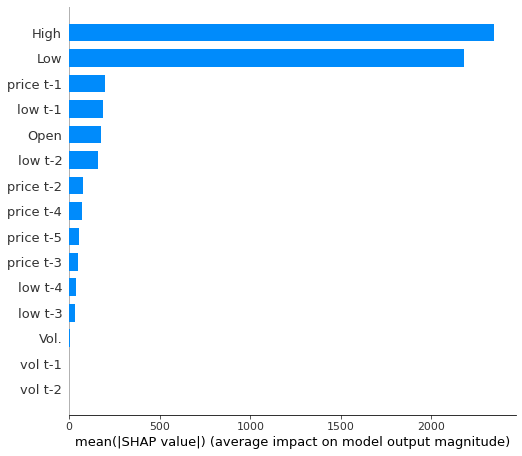

In [99]:
shap.summary_plot(shap_values, a, plot_type="bar")